# Tutorial: Epidemiology Models


## Computational Economics  (ECO309)



H.W. Heathcote: epidemiologic models are *deterministic models for infectious diseases which are spread by direct person-to-person contact in a population*.

This kind of models has been used since by a few decades by economist, for matters that have nothing to do with health.

- diffusion of information, or opinions on social medias
- asset prices and fads
- expectation formation for macroeconomic outcomes (ex: *The Epidemiology of Macroeconomic Expectations* by Chris Carroll)

Epidemiologic models have two features that depart from standard economic models:

- Agent's behaviour does not take the full system into account, an is irrational in the sense that it isn't forwards looking. Instead, an agent is given a behavioural heuristic.
- The transitions of the whole system can be determined without solving for complex interactions first.

Understanding why these two assumptions are very costly for economists will keep us busy during a big part of the course. Here we just consider two simple models as small programming exercises.

### Simple SIR model

There is a continuum of agents of mass $1$. Each agent can be either "Susceptible" (S), "Infected" (I) or "Recovered" (R).
In each period, one agent meets another agent drawn randomly.
During a meeting Susceptible agents who meet an infected agent, will always catch the disease (or the fad) but are not contagious. Infected agents, have a probability $\pi$ of being recovered. Nothing happens to Recovered agents who meet other people. No distinction is made between recovering as a healthy or a dead person.

We're interested in the evolution in the number infected persons, both the speed of infection and the total amount of infected people in every period.

__Write down the transition equations for $n_I$, the number of infected people, for $n_R$ the number of recovered people and $n_S$ the number of susceptible people.__



$$\begin{eqnarray}
n_{R,t+1} & = & n_{R,t} + \pi  n_{I,t}\\
n_{S,t+1} & = & n_{S,t} - n_{I,t} n_{S,t}\\
n_{I,t+1} & = & n_{I,t} + n_{I,t} n_{S,t} - \pi n_{I,t}
\end{eqnarray}$$

__Compute the transition function `f` for the vector state $s_t$ returning $s_{t+1}$. State is $s_t = (n_{S,t}, n_{I,t}, n_{R,t})$__



In [6]:
p = 0.1
s0 = [0.9, 0.1, 0.0]

function transition(s)
    n_S = s[1]
    n_I = s[2]
    n_R = s[3]
    
    N_S = n_S - n_I*n_S
    N_I = n_I + n_I*n_S - p*n_I
    N_R = n_R + p*n_I
    
    return [ N_S , N_I , N_R ]
end

transition (generic function with 2 methods)

In [7]:
transition(s0)

3-element Array{Float64,1}:
 0.81
 0.18
 0.010000000000000002

In [8]:
# two small improvements:
# 1. avoid defining p in the global scope: pass it as an argument instead
# 2. specify the type of the argument

function transition(s::Vector{Float64}; p=0.1)
    n_S = s[1]
    n_I = s[2]
    n_R = s[3]
    
    N_S = n_S - n_I*n_S
    N_I = n_I + n_I*n_S - p*n_I
    N_R = n_R + p*n_I
    
    return [ N_S , N_I , N_R ]
end


transition (generic function with 2 methods)

__Compute the transitions over $T$ periods. Plot the result using Plots.jl. (bonus: check against closed form solution)__



In [ ]:
# push! : add an element to an array

In [9]:
a = [1,2,3]
push!(a, 4)

4-element Array{Int64,1}:
 1
 2
 3
 4

In [10]:
# zeros: allocate array with zeros
zeros(5)

5-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0

In [18]:
function transition_easy(s0, T; p=0.1)
    result = [s0]
    for i = 1:T
        s = result[end]
        S = transition(s; p=p)
        push!( result, S)
        println("Iteration ", i)
        println(result)
    end
    return result
end
    

transition_easy (generic function with 1 method)

In [19]:
transition_easy(s0, 5)

Iteration 1
[[0.9, 0.1, 0.0], [0.81, 0.18, 0.010000000000000002]]
Iteration 2
[[0.9, 0.1, 0.0], [0.81, 0.18, 0.010000000000000002], [0.6642, 0.30779999999999996, 0.028]]
Iteration 3
[[0.9, 0.1, 0.0], [0.81, 0.18, 0.010000000000000002], [0.6642, 0.30779999999999996, 0.028], [0.45975924, 0.48146076, 0.05878]]
Iteration 4
[[0.9, 0.1, 0.0], [0.81, 0.18, 0.010000000000000002], [0.6642, 0.30779999999999996, 0.028], [0.45975924, 0.48146076, 0.05878], [0.2384032068925776, 0.6546707171074224, 0.10692607600000001]]
Iteration 5
[[0.9, 0.1, 0.0], [0.81, 0.18, 0.010000000000000002], [0.6642, 0.30779999999999996, 0.028], [0.45975924, 0.48146076, 0.05878], [0.2384032068925776, 0.6546707171074224, 0.10692607600000001], [0.08232760847550463, 0.7452792438137531, 0.17239314771074227]]


6-element Array{Array{Float64,1},1}:
 [0.9, 0.1, 0.0]
 [0.81, 0.18, 0.010000000000000002]
 [0.6642, 0.30779999999999996, 0.028]
 [0.45975924, 0.48146076, 0.05878]
 [0.2384032068925776, 0.6546707171074224, 0.10692607600000001]
 [0.08232760847550463, 0.7452792438137531, 0.17239314771074227]

In [45]:
function transition(s0::Array{Float64,1}, T::Int64; p=0.1)
    sim = zeros(T+1, 3)
    sim[1,:] = s0
    for i in 1:T
        s = sim[i,:]
        S = transition(s; p=p)
        sim[i+1,:] = S
    end
    return sim
end

transition (generic function with 4 methods)

In [46]:
sim = transition(s0, 50)

51×3 Array{Float64,2}:
 0.9          0.1         0.0
 0.81         0.18        0.01
 0.6642       0.3078      0.028
 0.459759     0.481461    0.05878
 0.238403     0.654671    0.106926
 0.0823276    0.745279    0.172393
 0.0209706    0.732108    0.246921
 0.00561783   0.67425     0.320132
 0.00183001   0.610613    0.387557
 0.000712581  0.550669    0.448618
 0.000320185  0.495995    0.503685
 0.000161375  0.446554    0.553285
 8.93123e-5   0.401971    0.59794
 ⋮                        
 1.19153e-6   0.023382    0.976617
 1.16367e-6   0.0210438   0.978955
 1.13919e-6   0.0189395   0.981059
 1.11761e-6   0.0170456   0.982953
 1.09856e-6   0.015341    0.984658
 1.08171e-6   0.0138069   0.986192
 1.06677e-6   0.0124263   0.987573
 1.05352e-6   0.0111836   0.988815
 1.04173e-6   0.0100653   0.989934
 1.03125e-6   0.00905877  0.99094
 1.02191e-6   0.0081529   0.991846
 1.01358e-6   0.00733762  0.992661

In [ ]:
# import Plots
# Plots.plot()

In [ ]:
# import Plots: plot    # from matplotlib import pyplot

In [49]:
using Plots # all exported functions become available

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


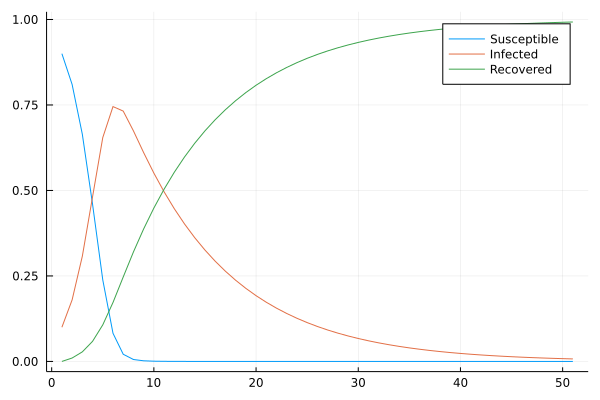

In [52]:
pl = plot( sim[:,1 ], label= "Susceptible")
plot!( sim[:, 2], label="Infected")
plot!( sim[:, 3], label="Recovered")
pl

__We now assume a Susceptible person who meets an infected one has a probability $\mu$ of catching the disease. Update the transition function. Update function $f$ and write a function of $\mu$, $\pi$ which returns the simulation. Compare different values of the parameters. How would you interpret "social distancing"? How would you choose parameters $\Pi$ and $\mu$__ 

New equations:
$$\begin{eqnarray}
n_{R,t+1} & = & n_{R,t} + \pi  n_{I,t}\\
n_{S,t+1} & = & n_{S,t} - \mu n_{I,t} n_{S,t}\\
n_{I,t+1} & = & n_{I,t} + \mu n_{I,t} n_{S,t} - \pi n_{I,t}
\end{eqnarray}$$

In [53]:
# 1. avoid defining p in the global scope: pass it as an argument instead
# 2. specify the type of the argument

function transition(s::Vector{Float64}; p=0.1, μ=1.0)
    n_S = s[1]
    n_I = s[2]
    n_R = s[3]
    
    N_S = n_S - μ*n_I*n_S
    N_I = n_I + μ*n_I*n_S - p*n_I
    N_R = n_R + p*n_I
    
    return [ N_S , N_I , N_R ]
end

transition (generic function with 4 methods)

In [54]:
function simulation(s0::Array{Float64,1}, T::Int64; p=0.1,  μ=1.0)
    sim = zeros(T+1, 3)
    sim[1,:] = s0
    for i in 1:T
        s = sim[i,:]
        S = transition(s; p=p, μ=μ)
        sim[i+1,:] = S
    end
    return sim
end

simulation (generic function with 1 method)

In [58]:
sim = simulation(s0, 50; μ=0.5) ; 

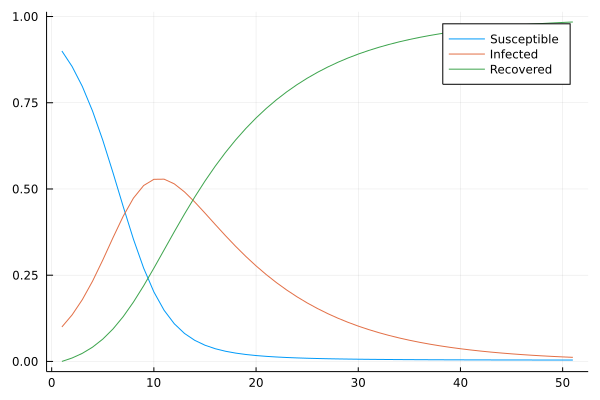

In [59]:
pl = plot( sim[:,1 ], label= "Susceptible")
plot!( sim[:, 2], label="Infected")
plot!( sim[:, 3], label="Recovered")
pl

In [68]:
sim1 = simulation(s0, 20; μ=0.2)
s1 = copy( sim1[end,:] )
s1[2] += s1[3]*0.1
s1[3] -= s1[3]*0.1
sim2 = simulation(s1, 20; μ=0.4)
fsim = cat(sim1, sim2; dims=1)

42×3 Array{Float64,2}:
 0.9        0.1       0.0
 0.882      0.108     0.01
 0.862949   0.116251  0.0208
 0.842885   0.12469   0.0324251
 0.821865   0.133241  0.0448941
 0.799964   0.141818  0.0582182
 0.777274   0.150326  0.0724
 0.753905   0.158662  0.0874325
 0.729982   0.166719  0.103299
 0.705642   0.174388  0.119971
 0.681031   0.18156   0.137409
 0.656301   0.188134  0.155565
 0.631607   0.194015  0.174379
 ⋮                    
 0.150126   0.285905  0.563969
 0.132958   0.274483  0.592559
 0.11836    0.261633  0.620008
 0.105973   0.247856  0.646171
 0.0954667  0.233577  0.670956
 0.0865472  0.219139  0.694314
 0.0789609  0.204811  0.716228
 0.072492   0.190799  0.736709
 0.0669595  0.177252  0.755789
 0.062212   0.164274  0.773514
 0.0581241  0.151934  0.789942
 0.0545917  0.140273  0.805135

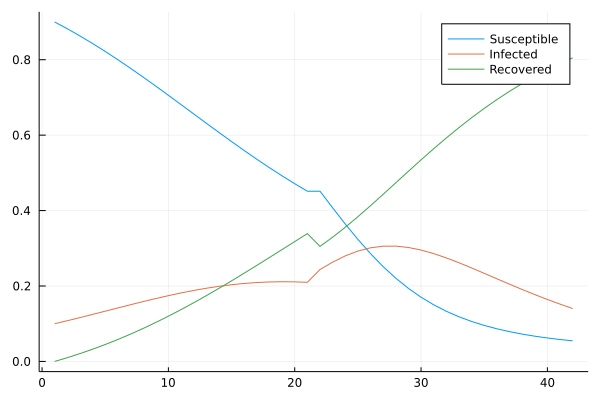

In [69]:
pl = plot( fsim[:,1 ], label= "Susceptible")
plot!( fsim[:, 2], label="Infected")
plot!( fsim[:, 3], label="Recovered")
pl

### A Spatial SIR model

We now consider another version of the model where agents evolve in the space $\mathcal{S}=[0,1]\times[0,1]$. There are $N\in\mathbb{N}$ agent. At any date, each agent $n \in [0,1]$  is located at $(x_n,y_n)\in \mathcal{S}$.

Each agent moves follows a random walk bounded by $\mathcal{S}$:
$$x_t = \min(\max( x_{t-1} + \epsilon_t, 0), 1)$$
$$y_t = \min(\max( y_{t-1} + \eta_t, 0), 1)$$
where $\epsilon_t$ and $\eta_t$ are both normally distributed with standard deviation $\sigma$.

At any date, the individual state of an agent is $s_t=(x_t, y_t, h_t)$ where $h_t$ is either "S", "I" or "R". $v_t$ denotes the states of all agents (for instance $v_t=(s_{n,t})_n$. The health status of each agent is updated in the following way:

- Agents $R$ stay $R$.
- Agents $I$ have probability $\pi$ to become $R$. They stay $I$ otherwise.
- An agent of type $S$ in position $(x,y)$ has a probability $prob(x,y,S)$ to be infected that is $\mu$ if there is another infected agent within a radius $r>0$.


__Define a type `Agent`, which holds the type of an agent. The state of the whole system will be held in a `Vector[Agent]` type.__



In [71]:
struct Agent
    x::Float64
    y::Float64
    state::Int8 # 0, 1 or 2
end

In [104]:
Agent(x,y) = Agent(x,y,0)
Agent() = Agent(rand(), rand()) #  creaates a random susceptible agent
Agent(state) = Agent(rand(), rand(), state) #  creaates a random agent of a given state

Agent

In [105]:
recovered(agent::Agent) = agent.state==2
infected(agent::Agent) = agent.state==1
susceptible(agent::Agent) = agent.state==0

susceptible (generic function with 1 method)

In [86]:
[Agent(), Agent()]   # Vector{Agent}

2-element Array{Agent,1}:
 Agent(0.024969309615699764, 0.3419651078942194, 0)
 Agent(0.8014953205638997, 0.9868962492647311, 0)

__Write a function `show_population` to plot all agents with different colors for different health status.__



In [118]:
N_1 = 90 # number of susceptible
N_2 = 10 # number of infected
distribution = [[Agent() for i=1:N_1] ; [Agent(1) for i=1:N_2]]

100-element Array{Agent,1}:
 Agent(0.961571409461373, 0.23501136602962114, 0)
 Agent(0.7810099276786675, 0.036190553333325104, 0)
 Agent(0.6324209539364642, 0.621138057067639, 0)
 Agent(0.5621593171063808, 0.7533365087739279, 0)
 Agent(0.43705796416020637, 0.16939080435200893, 0)
 Agent(0.13689239663389086, 0.23187329394260758, 0)
 Agent(0.12295836010024441, 0.0531747960767075, 0)
 Agent(0.21204999259579305, 0.6445001090009714, 0)
 Agent(0.971865630691322, 0.338117671705058, 0)
 Agent(0.020218400147317572, 0.2810797702368826, 0)
 Agent(0.5397159867886894, 0.06557902474940591, 0)
 Agent(0.9706394476784521, 0.3176170005017904, 0)
 Agent(0.3722270256264262, 0.676143049692381, 0)
 ⋮
 Agent(0.12883292782406364, 0.9388252810193871, 0)
 Agent(0.8202106454720606, 0.6914872085015962, 0)
 Agent(0.1762612884800252, 0.606349157686914, 1)
 Agent(0.05140915057197115, 0.06922027236861439, 1)
 Agent(0.09455715602757775, 0.6663252633953551, 1)
 Agent(0.19617621574120214, 0.6751828148312717, 1)
 Agent(0

In [121]:
function show_population(population::Vector{Agent})
    xvec_S = [agent.x for agent in population if susceptible(agent)]
    yvec_S = [agent.y for agent in population if susceptible(agent)]
    xvec_I = [agent.x for agent in population if infected(agent)]
    yvec_I = [agent.y for agent in population if infected(agent)]
    pl = scatter(xvec_S, yvec_S, label="Susceptible")
    scatter!(pl, xvec_I, yvec_I, label="Infected")
    return pl
end

show_population (generic function with 1 method)

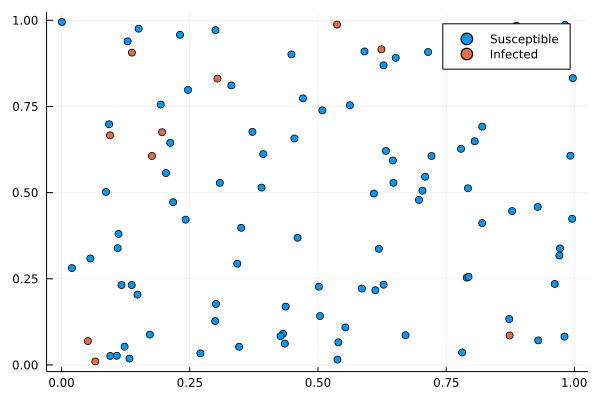

In [122]:
show_population(distribution)

__Write a function `spatial_transition(S::Vector{Agent})::Vector{Agent}` to compute the transition of the positions. Write another function `random_guess(T=100)` which simulates for $T$ periods in order to find a good initial guess.__



__Write a function `evolve(S::Vector[Agent])::Vector[Agent]` which takes the population in a given state and returns the same population with updated health status.__



__Write a function `simulate(S0::Vector[Agent], k=1)` to simulate the economy starting from an initially random position with `k` infected individuals. The returned object should be of type `Vector[Vector[Agent]]`.__



__Compute statistics along a simulated path for $n_I$, $n_S$, $n_R$. Plot and compare with the basic SIR model__

### Additional questions

Have fun by trying to answer one of these questions:
- change probability of infection so that it depends on the number of infected people in the vincinity (with some suitable functional formulation for)
- compute an animation of the transition
- compute an interactive visualisation (with `Interact.jl` if available)